#Analysis of CrowdFlower job #754530: abstract-level chemical-induced disease relation extraction for BioCreative V

Tong Shu Li<br>
Created on Tuesday 2015-07-21<br>
Last updated 2015-07-21

Previous work with CrowdFlower tasks #746297 and #748223 showed that:

1. Workers performed best on relations which were sentence bound.
2. Workers missed some relations when multiple relations were presented.
3. Workers picked out the easiest relations to verify when multiple relations were presented.
4. Concept name replacement with the semantic type had little influence on performance.

Based on these observations, I decided to make the following changes:

1. Split the task into two subtasks: one where the relation is sentence bound, and one where the relation is not sentence bound. While the underlying task is almost identical, this allows payments to be structured differently and hopefully for tasks to be processed faster.
2. Reduce the number of relations to verify for each passage of text from five to one. This allows each judgement to be simplified to a binary judgement.

This notebook will analyze the results of the abstract-level task.

Parameter | Value
--- | ---
Job ID | #754530
Rows per page | 5
Judgements per row | 5
Payment per page | 25 cents USD
Contributor level | 2
Minimum time per page | 30 seconds
Minimum accuracy threshold | 70%
Number of test questions | 14
Date of launch | 5:00 pm on Monday, July 20, 2015
Date of completion | 9:00 am on Tuesday, July 21, 2015
Total cost before bonuses | \$43.20 USD
Total cost after bonuses | $43.32 USD

---

In [1]:
from __future__ import division
from collections import Counter
from collections import defaultdict
from operator import add
import matplotlib as plt
import os
import pandas as pd
import pickle

In [2]:
matplotlib inline

In [3]:
from src.filter_data import filter_data
from src import data_model
from src.data_model import parse_input
from src.data_model import Relation

###Read the results of job #754530:

In [4]:
settings = {
    "loc": "data/crowdflower/results",
    "fname": "job_754530_full_with_untrusted.csv",
    "data_subset": "normal",
    "min_accuracy": 0.7,
    "max_accuracy": 1.0
}

raw_data = filter_data(settings)

In [5]:
raw_data.head()

,_unit_id,_created_at,_golden,_id,_missed,_started_at,_tainted,_channel,_trust,_worker_id,...,disease_id,disease_name,drug_id,drug_name,form_abstract,form_title,pmid,uniq_id,verify_relationship_gold,worker_confidence_gold
0,756359591,7/21/2015 00:30:42,False,1694432011,NaN,7/21/2015 00:29:52,False,gifthunterclub,0.7857,27920569,...,D017180,"<span class=""disease"">ventricular tachycardia<...",C063968,"<span class=""chemical"">E4031</span>",1. Torsades de pointes (TDP) is a potentially ...,Pharmacokinetic/pharmacodynamic assessment of ...,11569530,bcv_hard_0,NaN,NaN
1,756359591,7/21/2015 00:32:50,False,1694432585,NaN,7/21/2015 00:29:59,False,clixsense,1.0000,20404755,...,D017180,"<span class=""disease"">ventricular tachycardia<...",C063968,"<span class=""chemical"">E4031</span>",1. Torsades de pointes (TDP) is a potentially ...,Pharmacokinetic/pharmacodynamic assessment of ...,11569530,bcv_hard_0,NaN,NaN
2,756359591,7/21/2015 00:35:07,False,1694433298,NaN,7/21/2015 00:30:09,False,instagc,0.8182,27770607,...,D017180,"<span class=""disease"">ventricular tachycardia<...",C063968,"<span class=""chemical"">E4031</span>",1. Torsades de pointes (TDP) is a potentially ...,Pharmacokinetic/pharmacodynamic assessment of ...,11569530,bcv_hard_0,NaN,NaN
3,756359591,7/21/2015 00:35:25,False,1694433370,NaN,7/21/2015 00:30:13,False,neodev,0.9091,33534395,...,D017180,"<span class=""disease"">ventricular tachycardia<...",C063968,"<span class=""chemical"">E4031</span>",1. Torsades de pointes (TDP) is a potentially ...,Pharmacokinetic/pharmacodynamic assessment of ...,11569530,bcv_hard_0,NaN,NaN
4,756359591,7/21/2015 01:09:42,False,1694443215,NaN,7/21/2015 01:00:51,False,points4rewards,0.8889,20113482,...,D017180,"<span class=""disease"">ventricular tachycardia<...",C063968,"<span class=""chemical"">E4031</span>",1. Torsades de pointes (TDP) is a potentially ...,Pharmacokinetic/pharmacodynamic assessment of ...,11569530,bcv_hard_0,NaN,NaN


In [6]:
raw_data.shape

(485, 27)

In [7]:
raw_data.columns.values

array(['_unit_id', '_created_at', '_golden', '_id', '_missed',
       '_started_at', '_tainted', '_channel', '_trust', '_worker_id',
       '_country', '_region', '_city', '_ip', 'comment_box',
       'verify_relationship', 'worker_confidence', 'disease_id',
       'disease_name', 'drug_id', 'drug_name', 'form_abstract',
       'form_title', 'pmid', 'uniq_id', 'verify_relationship_gold',
       'worker_confidence_gold'], dtype=object)

###Preprocessing:

This time, the judgements were binary, and therefore there is no ability for inconsistency in a single worker's judgements. Therefore we do not need to do the consistency check that we performed for jobs #746297 and #748223.

We will look at the comments before proceeding to analysis.

In [8]:
Counter(raw_data["worker_confidence"])

Counter({'very_confident': 232, 'confident': 222, 'not_too_confident': 29, 'not_confident': 2})

I personally doubt whether the confidence indicator is valuable at all, since very few people rate themselves as not being confident in an answer. People are usually confident in their answer, so it doesn't help very much.

###Comments:

In [9]:
raw_data["comment_box"].unique()

array([nan, 'this test question is wrong',
       'All three chemicals {(131 mg/m(2) for paclitaxel (97.3%), 117 mg/m(2) for cisplatin (97.3%), and 1378 mg/m(2) for gemcitabine (86.2% )}  listed are  responsible for the cause of disease.',
       'wrong test question',
       'All the above three chemicals [31 mg/m(2) for paclitaxel (97.3%), 117 mg/m(2) for cisplatin (97.3%), and 1378 mg/m(2) for gemcitabine (86.2%)] are responsible in causing the disease .',
       'Proofs provided aren-t strong enough to relate the disease to the drug',
       'This may well be a particularly notable finding in Asian people.'], dtype=object)

###Test question contentions:

Three test questions had a few contentions:

PMID | Unit ID | Unique ID
--- | --- | ---
11569530 | 756407963 | bcv_hard_1
15632880 | 756407799 | bcv_hard_49
11135224 | 756400982 | bcv_hard_5

For bcv_hard_1, the question asked what the relationship between "cisapride" and "ventricular tachycardia" was. The text clearly says that cisapride causes TDP (Torsades de pointes), and that TDP "is a potentially fatal ventricular tachycardia".

Some workers contend that the text is saying that cisapride indirectly causes ventricular tachycardia through TDP, instead of no relationship. I put "no relation" as the correct answer because ventricular tachycardia is a superclass of TDP, and therefore the causation cannot be direct. The problem now lies in whether we should count this as an indirect cause, different from when the text says something like "drug induced disease A causes disease B". The real problem is whether we treat the "is a" relationship as a "causes" relationship.

At this time I have not determined the best way to resolve this conflict. The gold standard says that the relationship does not exist.

For bcv_hard_49, the question is what this passage of text means:
> Sixty-seven of 926 patients (7.2%) required discontinuation of spironolactone due to hyperkalemia (n = 33) or renal failure (n = 34). Patients who developed hyperkalemia were older and more likely to have diabetes, had higher baseline serum potassium levels and lower baseline potassium supplement doses, and were more likely to be treated with beta-blockers than controls (n = 134).

I believe that this means that the patients had diabetes prior to being given the drug, and not that they developed diabetes after receiving the drug, as some workers contended. Specifically the workers chose the indirect relationship choice of spironolactone -> hyperkalemia -> diabetes.

Finally, the last contention for bcv_hard_5 was to say that paclitaxel does not cause death, since it is the combination of three drugs which resulted in one death. This is a bit problematic, since the gold also says that this relation does not exist, but as for the contention, I made it clear in the instructions that the drug could work by itself or with other drugs, so I did not forgive the contentions.

---

###Result aggregation:

In [10]:
# last updated 2015-07-21 Tong Shu Li
def aggregate_votes(column_name, data_frame, mapping = None):
    """
    Given all of the human responses for one work unit,
    aggregates the results based on the column you give it.

    For each possible choice, it calculates:
        1. Total number of votes
        2. Confidence score

    Returns an unsorted data frame of the results.

    Confidence score is the sum of the trust score of
    individual workers.
    
    If given a mapping, will convert answers.
    """
    res = dict()
    for value, group in data_frame.groupby(column_name):
        conf_score = sum(group["_trust"])
        num_votes = len(group)
        
        if mapping is not None:
            value = mapping[value]
            
        if value in res:
            res[value] = map(add, res[value], [conf_score, num_votes])
        else:
            res[value] = [conf_score, num_votes]
            
    temp = [[key] + value for key, value in res.items()]
    return pd.DataFrame(temp, columns = [column_name, "conf_score", "num_votes"])

In [11]:
# last updated 2015-04-16 Tong Shu Li
"""
Takes raw CrowdFlower data and groups data together by
individual work units. Aggregates the votes based on
a specific column and creates a summary data frame.
"""
def aggregate_results(id_column, agg_column, data, mapping = None):
    result = []
    for identifier, group in data.groupby(id_column):
        ans = aggregate_votes(agg_column, group, mapping)

        total_vote_score = sum(ans["conf_score"])
        percent_agree = ans["conf_score"] / total_vote_score

        ans["percent_agree"] = percent_agree
        ans.insert(0, id_column, identifier)
        
        ans["pmid"] = group["pmid"].iloc[0]
        ans["unit_id"] = group["_unit_id"].iloc[0]

        ans = ans.sort(["conf_score"], ascending = False)

        result.append(ans)

    return pd.concat(result)

In [12]:
res = aggregate_results("uniq_id", "verify_relationship", raw_data)

In [13]:
res.head()

,uniq_id,verify_relationship,conf_score,num_votes,percent_agree,pmid,unit_id
0,bcv_hard_0,no_relation,4.4019,5,1.000000,11569530,756359591
2,bcv_hard_1,no_relation,1.7142,2,0.404493,11569530,756359592
1,bcv_hard_1,yes_direct,1.6904,2,0.398877,11569530,756359592
0,bcv_hard_1,yes_indirect,0.8333,1,0.196630,11569530,756359592
0,bcv_hard_10,yes_direct,4.4417,5,1.000000,11135224,756359601


There are two ways to map the results:

1. Convert yes_indirect to a "yes"
2. Convert yes_indirect to a "no"

In [14]:
mapping1 = {
    "yes_direct": "yes_relation",
    "yes_indirect": "yes_relation",
    "no_relation": "no_relation"
}

mapping2 = {
    "yes_direct": "yes_relation",
    "yes_indirect": "no_relation",
    "no_relation": "no_relation"
}

res_yes = aggregate_results("uniq_id", "verify_relationship", raw_data, mapping1)
res_no = aggregate_results("uniq_id", "verify_relationship", raw_data, mapping2)

In [15]:
res_yes.head()

,uniq_id,verify_relationship,conf_score,num_votes,percent_agree,pmid,unit_id
0,bcv_hard_0,no_relation,4.4019,5,1.000000,11569530,756359591
0,bcv_hard_1,yes_relation,2.5237,3,0.595507,11569530,756359592
1,bcv_hard_1,no_relation,1.7142,2,0.404493,11569530,756359592
0,bcv_hard_10,yes_relation,4.4417,5,1.000000,11135224,756359601
0,bcv_hard_11,yes_relation,3.5659,4,0.819446,11135224,756359602


In [16]:
res_no.head()

,uniq_id,verify_relationship,conf_score,num_votes,percent_agree,pmid,unit_id
0,bcv_hard_0,no_relation,4.4019,5,1.000000,11569530,756359591
1,bcv_hard_1,no_relation,2.5475,3,0.601123,11569530,756359592
0,bcv_hard_1,yes_relation,1.6904,2,0.398877,11569530,756359592
0,bcv_hard_10,yes_relation,4.4417,5,1.000000,11135224,756359601
0,bcv_hard_11,yes_relation,3.5659,4,0.819446,11135224,756359602


---

###Read the gold standard:

In [17]:
if os.path.exists("data/training/parsed_training_set.pickle"):
    print "Reading cached version of training set"
    with open("data/training/parsed_training_set.pickle", "rb") as fin:
        training_data = pickle.load(fin)
else:
    training_data = parse_input("data/training", "CDR_TrainingSet.txt")
    with open("data/training/parsed_training_set.pickle", "wb") as fout:
        pickle.dump(training_data, fout)

Reading cached version of training set


In [18]:
testset_pmids = set(raw_data["pmid"].unique())

In [19]:
testset_pmids

{1130930,
 1378968,
 1835291,
 2096243,
 2265898,
 2375138,
 3800626,
 6666578,
 7449470,
 7582165,
 8590259,
 8595686,
 9522143,
 10835440,
 11135224,
 11569530,
 12198388,
 15602202,
 15632880,
 16167916,
 16337777,
 17241784,
 17261653,
 18631865}

In [20]:
def get_subset(dataset, papers):
    return {paper.pmid : paper for paper in papers if paper.pmid in dataset}

testset = get_subset(testset_pmids, training_data)

We have fewer than the original 30 work units because some of them had relations which were exclusively sentence-bound.

In [21]:
len(testset)

24

---

###Evaluate crowd performance against the gold standard:

We will now check how the crowd did against the gold standard. To do this we will take the top answer as the official crowd response and compare it to the gold.

In [22]:
def get_class(in_gold, crowd_resp):
    mapping = {
        True : {
            "yes_relation": "true_pos",
            "no_relation": "false_neg"
        },
        False : {
            "yes_relation": "false_pos",
            "no_relation": "true_neg"
        }
    }
    
    return mapping[in_gold][crowd_resp]

In [23]:
def evaluate_performance(results, raw_data, gold_std):
    """
    Summarizes the crowd's performance against the gold standard
    and returns a summary dataframe.
    """
    res = defaultdict(list)
    
    for uniq_id, group in results.groupby("uniq_id"):
        assert len(group["pmid"].unique()) == 1
        pmid = group["pmid"].iloc[0]
        
        # grab the relation pair for this work unit
        datarow = raw_data.query("uniq_id == '{0}'".format(uniq_id)).iloc[0]
        
        chemical_id = datarow["drug_id"]
        disease_id = datarow["disease_id"]
        
        rel = Relation(chemical_id, disease_id)
        
        in_gold = gold_std[pmid].has_relation(rel)
        
        # now we check if the crowd's answer matched the gold
        crowd_ans = group["verify_relationship"].iloc[0]
        assert crowd_ans in ["yes_relation", "no_relation"], crowd_ans
        
        res["pmid"].append(pmid)
        res["uniq_id"].append(uniq_id)
        res["unit_id"].append(datarow["_unit_id"])
        
        res["chemical_id"].append(chemical_id)
        res["disease_id"].append(disease_id)
        
        res["in_gold"].append(in_gold)
        res["top_crowd_response"].append(crowd_ans)
        
        res["num_votes"].append(group["num_votes"].iloc[0])
        res["percent_agree"].append(group["percent_agree"].iloc[0])
        
        res["ans_class"].append(get_class(in_gold, crowd_ans))
        
    return pd.DataFrame(res)

In [24]:
perf_yes = evaluate_performance(res_yes, raw_data, testset)

In [25]:
perf_yes.head()

,ans_class,chemical_id,disease_id,in_gold,num_votes,percent_agree,pmid,top_crowd_response,uniq_id,unit_id
0,true_neg,C063968,D017180,False,5,1.000000,11569530,no_relation,bcv_hard_0,756359591
1,false_pos,D020117,D017180,False,3,0.595507,11569530,yes_relation,bcv_hard_1,756359592
2,true_pos,C056507,D013921,True,5,1.000000,11135224,yes_relation,bcv_hard_10,756359601
3,false_pos,C056507,D003643,False,4,0.819446,11135224,yes_relation,bcv_hard_11,756359602
4,true_pos,C056507,D009503,True,4,0.784342,11135224,yes_relation,bcv_hard_12,756359603


In [26]:
def F_score(precision, recall):
    return 2 * (precision * recall) / (precision + recall)

def perf_statistics(perf_summary):
    """
    Calculates true pos, false pos, true neg, and false neg
    values for a performance summary dataframe.
    
    Also calculates precision, recall, and F score.
    """
    true_pos = len(perf_summary.query("ans_class == 'true_pos'"))
    true_neg = len(perf_summary.query("ans_class == 'true_neg'"))
    
    false_pos = len(perf_summary.query("ans_class == 'false_pos'"))
    false_neg = len(perf_summary.query("ans_class == 'false_neg'"))
    
    assert true_pos + true_neg + false_pos + false_neg == len(perf_summary)
    
    print "true pos", true_pos
    print "true neg", true_neg
    print "false pos", false_pos
    print "false neg", false_neg
    print
    
    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)
    
    print "precision", precision
    print "recall", recall
    
    print "F score", F_score(precision, recall)

In [27]:
perf_statistics(perf_yes)

true pos 21
true neg 55
false pos 21
false neg 0

precision 0.5
recall 1.0
F score 0.666666666667


In [28]:
perf_no = evaluate_performance(res_no, raw_data, testset)
perf_statistics(perf_no)

true pos 21
true neg 58
false pos 18
false neg 0

precision 0.538461538462
recall 1.0
F score 0.7


###Thoughts:

The performance statistics don't seem too great at first glance. While it's good that there are no false negatives, I am concerned about the number of false positives in the results. 18 false positives in a set of 97 is 18.6%, which is pretty high. Let's look through these false positives by hand and see if there is something that we are missing.

The false positives:

In [29]:
false_positives = perf_no.query("ans_class == 'false_pos'")

In [30]:
false_positives.sort("percent_agree", ascending = False)

,ans_class,chemical_id,disease_id,in_gold,num_votes,percent_agree,pmid,top_crowd_response,uniq_id,unit_id
11,false_pos,D015742,D014474,False,5,1.000000,8595686,yes_relation,bcv_hard_19,756359610
83,false_pos,D005839,D007674,False,5,1.000000,1130930,yes_relation,bcv_hard_84,756359675
17,false_pos,D010862,D004827,False,5,1.000000,16337777,yes_relation,bcv_hard_24,756359615
65,false_pos,D000305,D004342,False,5,1.000000,7582165,yes_relation,bcv_hard_68,756359659
3,false_pos,C056507,D003643,False,4,0.819446,11135224,yes_relation,bcv_hard_11,756359602
85,false_pos,D002512,D007674,False,4,0.803878,1130930,yes_relation,bcv_hard_86,756359677
19,false_pos,D011318,D006319,False,4,0.791880,9522143,yes_relation,bcv_hard_26,756359617
88,false_pos,D017963,D007674,False,4,0.788871,15602202,yes_relation,bcv_hard_89,756359680
78,false_pos,D002945,D003643,False,4,0.786219,11135224,yes_relation,bcv_hard_8,756359599
59,false_pos,D009241,D002318|D005767,False,3,0.630163,1835291,yes_relation,bcv_hard_62,756359653


In [31]:
true_negatives = perf_no.query("ans_class == 'true_neg'")

In [33]:
true_negatives.sort("percent_agree", ascending = False)

,ans_class,chemical_id,disease_id,in_gold,num_votes,percent_agree,pmid,top_crowd_response,uniq_id,unit_id
0,true_neg,C063968,D017180,False,5,1.000000,11569530,no_relation,bcv_hard_0,756359591
74,true_neg,D003000,D006333,False,5,1.000000,17261653,no_relation,bcv_hard_76,756359667
41,true_neg,D049971,D006333,False,5,1.000000,15632880,no_relation,bcv_hard_46,756359637
42,true_neg,D049971,D006947,False,5,1.000000,15632880,no_relation,bcv_hard_47,756359638
43,true_neg,D049971,D003920,False,5,1.000000,15632880,no_relation,bcv_hard_48,756359639
44,true_neg,D013148,D003920,False,5,1.000000,15632880,no_relation,bcv_hard_49,756359640
52,true_neg,D012964,D014202,False,5,1.000000,12198388,no_relation,bcv_hard_56,756359647
54,true_neg,D011188,D012640,False,5,1.000000,12198388,no_relation,bcv_hard_58,756359649
55,true_neg,D011188,D014202,False,5,1.000000,12198388,no_relation,bcv_hard_59,756359650
72,true_neg,D003000,D001145,False,5,1.000000,17261653,no_relation,bcv_hard_74,756359665


In [34]:
true_positives = perf_no.query("ans_class == 'true_pos'")

In [35]:
true_positives.sort("percent_agree", ascending = False)

,ans_class,chemical_id,disease_id,in_gold,num_votes,percent_agree,pmid,top_crowd_response,uniq_id,unit_id
2,true_pos,C056507,D013921,True,5,1.000000,11135224,yes_relation,bcv_hard_10,756359601
61,true_pos,D010248,D014581,True,5,1.000000,7582165,yes_relation,bcv_hard_64,756359655
71,true_pos,D008874,D012140|D002318,True,5,1.000000,2375138,yes_relation,bcv_hard_73,756359664
70,true_pos,D004317,D009202,True,5,1.000000,7449470,yes_relation,bcv_hard_72,756359663
27,true_pos,C009265,D004827,True,5,1.000000,2265898,yes_relation,bcv_hard_33,756359624
32,true_pos,D010396,D001018,True,5,1.000000,6666578,yes_relation,bcv_hard_38,756359629
34,true_pos,D017239,D013921,True,5,1.000000,11135224,yes_relation,bcv_hard_4,756359595
47,true_pos,C016986,D003316,True,5,1.000000,8590259,yes_relation,bcv_hard_51,756359642
67,true_pos,D002945,D013921,True,5,1.000000,11135224,yes_relation,bcv_hard_7,756359598
50,true_pos,C016986,D004774,True,5,1.000000,8590259,yes_relation,bcv_hard_54,756359645


The agreement percentage for the false positives is markedly lower than that for both the true positives and the true negatives. This suggests to me again that the gold standard may be wrong and/or the question ambiguous/difficult.

(0.5, 1)

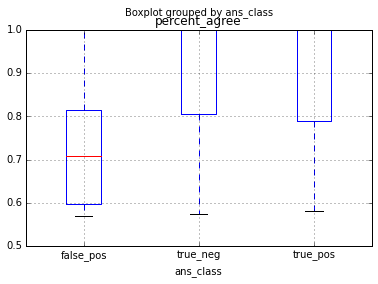

In [36]:
graph = perf_no.boxplot(column = "percent_agree", by = "ans_class")

graph.set_ylim((0.5, 1))

###Analysis of all "errors":

Now that we can see that the crowd is not as confident about the false positives, we can go through each of them individually and see what went wrong.

We will also sample the bottom confidence portions of each of the three categories to see if there is ambiguity that is leading to low agreement.